In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    label_binarize,
    LabelEncoder,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
    StratifiedKFold
)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    accuracy_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


In [ ]:
df = pd.read_csv('/content/car_price_prediction.csv')
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


# Primeira etapa: pré processamento

In [ ]:
df.dtypes

,0
ID,int64
Price,int64
Levy,object
Manufacturer,object
Model,object
Prod. year,int64
Category,object
Leather interior,object
Fuel type,object
Engine volume,object


In [ ]:
print(df.isnull().sum())
print(df.duplicated().value_counts())
df = df.drop_duplicates()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64
False    18924
True       313
Name: count, dtype: int64


In [ ]:
colunas = [col for col in df.columns if col != "Price"] + ["Price"]
df = df[colunas]

In [ ]:
df.shape

(18924, 18)

In [ ]:
#print(df['Manufacturer'].value_counts())
print(df['Model'].value_counts())

Model
Prius               1069
Sonata              1067
Camry                929
Elantra              910
E 350                534
                    ... 
Vito Exstralong        1
Versa SE               1
Fusion HYBRID SE       1
C30                    1
Optima k5              1
Name: count, Length: 1590, dtype: int64


In [ ]:
print(df['Manufacturer'].unique())

['LEXUS' 'CHEVROLET' 'HONDA' 'FORD' 'HYUNDAI' 'TOYOTA' 'MERCEDES-BENZ'
 'OPEL' 'PORSCHE' 'BMW' 'JEEP' 'VOLKSWAGEN' 'AUDI' 'RENAULT' 'NISSAN'
 'SUBARU' 'DAEWOO' 'KIA' 'MITSUBISHI' 'SSANGYONG' 'MAZDA' 'GMC' 'FIAT'
 'INFINITI' 'ALFA ROMEO' 'SUZUKI' 'ACURA' 'LINCOLN' 'VAZ' 'GAZ' 'CITROEN'
 'LAND ROVER' 'MINI' 'DODGE' 'CHRYSLER' 'JAGUAR' 'ISUZU' 'SKODA'
 'DAIHATSU' 'BUICK' 'TESLA' 'CADILLAC' 'PEUGEOT' 'BENTLEY' 'VOLVO' 'სხვა'
 'HAVAL' 'HUMMER' 'SCION' 'UAZ' 'MERCURY' 'ZAZ' 'ROVER' 'SEAT' 'LANCIA'
 'MOSKVICH' 'MASERATI' 'FERRARI' 'SAAB' 'LAMBORGHINI' 'ROLLS-ROYCE'
 'PONTIAC' 'SATURN' 'ASTON MARTIN' 'GREATWALL']


In [ ]:
df['Levy'] = pd.to_numeric(df['Levy'], errors = 'coerce')
df['Levy'] = df['Levy'].fillna(df['Levy'].mean())

In [ ]:
df['Cylinders'] = df['Cylinders'].astype(int)
df['Cylinders'].unique()

array([ 6,  4,  8,  1, 12,  3,  2, 16,  5,  7,  9, 10, 14])

In [ ]:
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')
df['Engine volume'] = df['Engine volume'].fillna(df['Engine volume'].mean())

In [ ]:
df['Mileage'] = df['Mileage'].str.replace('km', '')
df['Mileage'] = df['Mileage'].str.replace(',', '')
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

In [ ]:
df = df.drop(['ID'], axis=1)

In [ ]:
df['Model'].value_counts()

,count
Model,
Prius,1069
Sonata,1067
Camry,929
Elantra,910
E 350,534
...,...
Vito Exstralong,1
Versa SE,1
Fusion HYBRID SE,1


In [ ]:
# Filtrar modelos com pelo menos 50 ocorrências
model_counts = df['Model'].value_counts()
df_filtered = df[df['Model'].isin(model_counts[model_counts >= 50].index)]


In [ ]:
df_filtered.shape

(13258, 17)

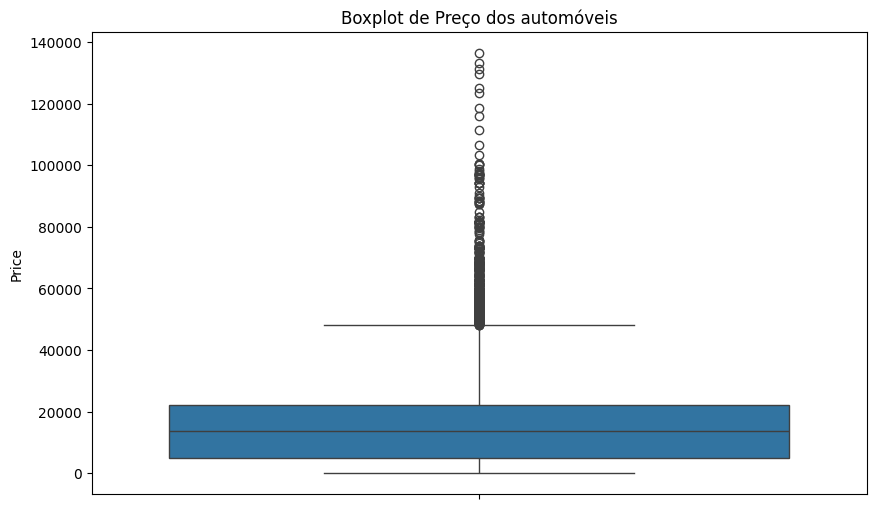

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_filtered['Price'])
plt.title('Boxplot de Preço dos automóveis')
plt.show()

/tmp/ipython-input-23-3477707410.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_manu.values, y=top_manu.index, palette="viridis")
/tmp/ipython-input-23-3477707410.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_models.values, y=top_models.index, palette="magma")
/tmp/ipython-input-23-3477707410.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="Set3")


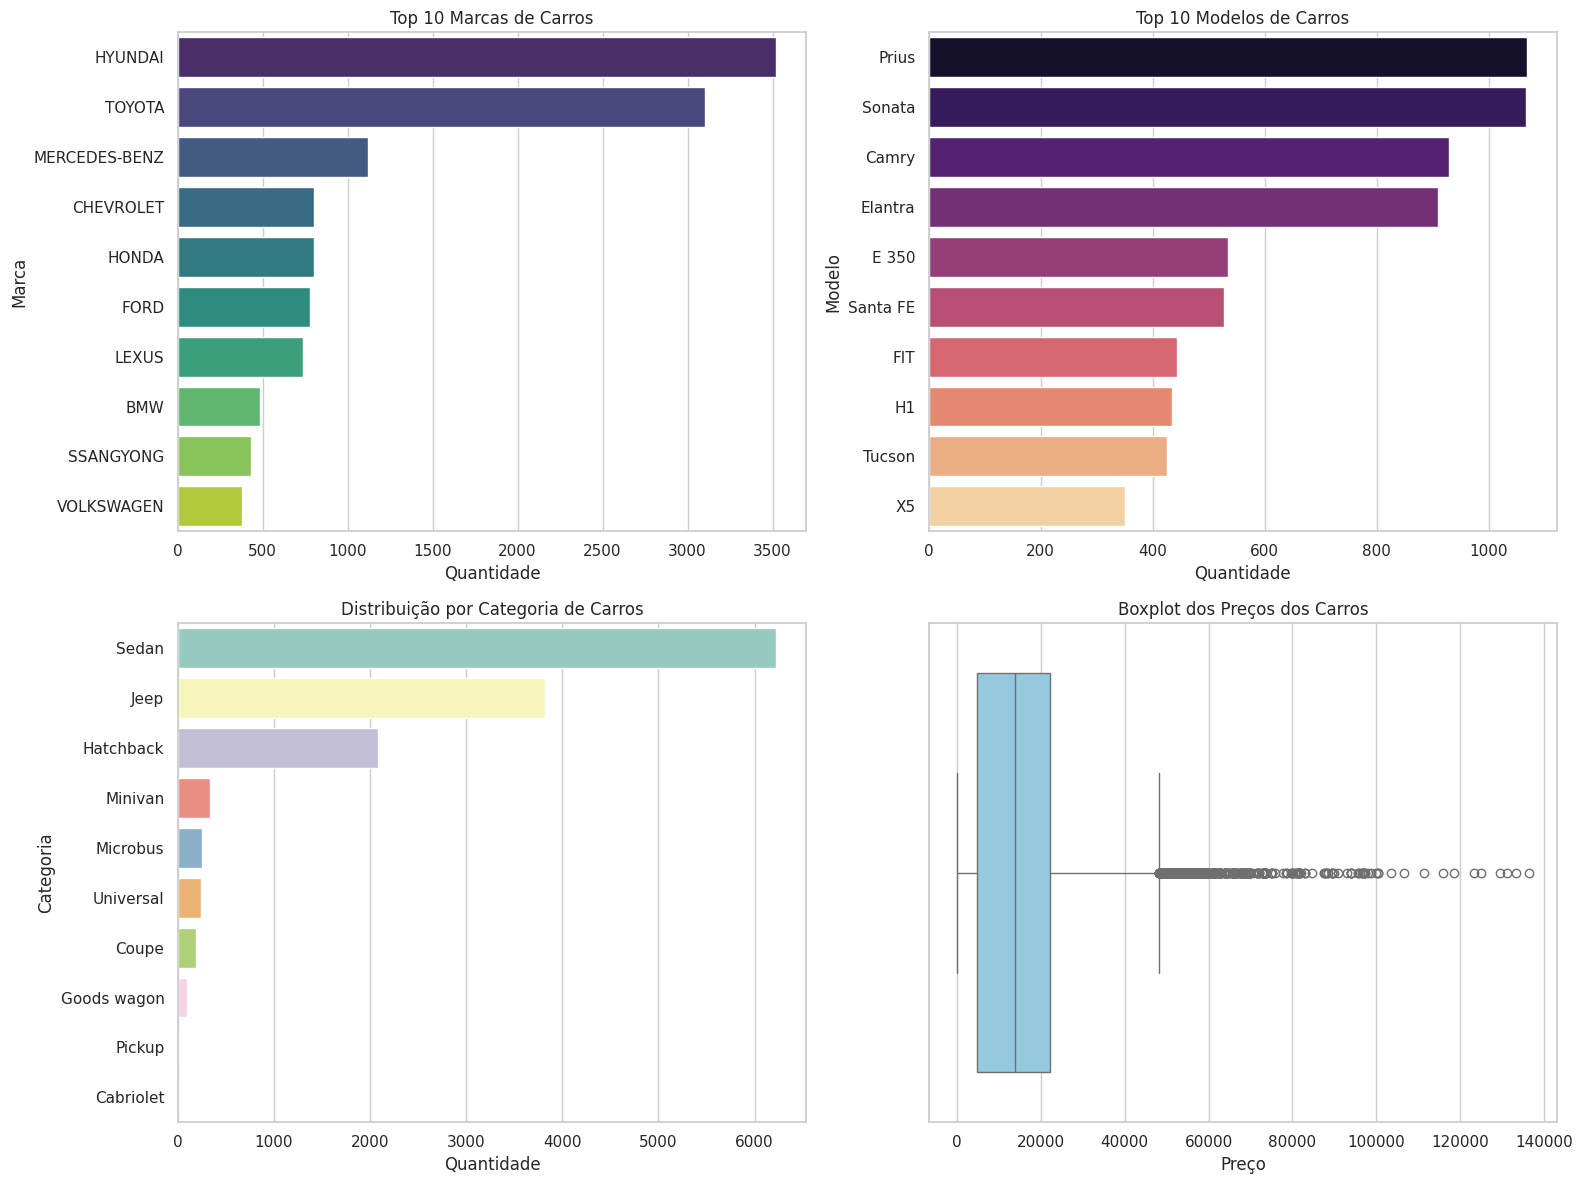

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))  # Tamanho total da figura

# --- 1. Top 10 Marcas (Manufacturer) ---
plt.subplot(2, 2, 1)
top_manu = df_filtered['Manufacturer'].value_counts().head(10)
sns.barplot(x=top_manu.values, y=top_manu.index, palette="viridis")
plt.title('Top 10 Marcas de Carros')
plt.xlabel('Quantidade')
plt.ylabel('Marca')

# --- 2. Top 10 Modelos (Model) ---
plt.subplot(2, 2, 2)
top_models = df_filtered['Model'].value_counts().head(10)
sns.barplot(x=top_models.values, y=top_models.index, palette="magma")
plt.title('Top 10 Modelos de Carros')
plt.xlabel('Quantidade')
plt.ylabel('Modelo')

# --- 3. Gráfico de Pizza (Categoria dos Carros) ---
plt.subplot(2,2,3)
category_counts = df_filtered['Category'].value_counts()
sns.barplot(x=category_counts.values, y=category_counts.index, palette="Set3")
plt.title('Distribuição por Categoria de Carros')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')


# --- 4. Boxplot de Preços ---
plt.subplot(2, 2, 4)
sns.boxplot(x=df_filtered['Price'], color="skyblue")
plt.title('Boxplot dos Preços dos Carros')
plt.xlabel('Preço')

plt.tight_layout()
plt.show()

In [ ]:
X  = df_filtered.drop(['Price'], axis=1)
y = df_filtered['Price']

In [ ]:
X['car_age'] = 2025 - X['Prod. year']
X.drop('Prod. year', axis=1, inplace=True)

In [ ]:
#df_filtered.drop('Prod. year', axis = 1, inplace= True )

In [ ]:
df_filtered.shape

(13258, 17)

In [ ]:
print(len(X['Model'].unique()))
print(len(X['Manufacturer'].unique()))

64
17


In [ ]:

categorical_cols = ['Manufacturer', 'Model','Color', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Doors', 'Wheel', 'Drive wheels']
numeric_cols = ['Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'car_age']
# Log-transform no target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [ ]:
# Função para capear outliers
def cap_outliers(X):
    X_capped = X.copy()
    for col in X.columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        X_capped[col] = X[col].clip(lower=lower, upper=upper)
    return X_capped


In [ ]:
# Pré-processamento numérico
X_train_numeric = cap_outliers(X_train[numeric_cols])
X_test_numeric = cap_outliers(X_test[numeric_cols])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Pré-processamento categórico
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Modelo 1 RandomForest Regressor

In [ ]:
# Combina os dados pré-processados
X_train_final = np.hstack([X_train_scaled, X_train_cat])
X_test_final = np.hstack([X_test_scaled, X_test_cat])

# Modelo de Random Forest
regressor = RandomForestRegressor()
regressor.fit(X_train_final, y_train_log)

# Previsão
y_pred_log = regressor.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

In [ ]:
# Validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_full_numeric = cap_outliers(X_train[numeric_cols])
X_train_full_scaled = scaler.fit_transform(X_train_full_numeric)
X_train_full_cat = encoder.fit_transform(X_train[categorical_cols])
X_train_full_final = np.hstack([X_train_full_scaled, X_train_full_cat])

scores = cross_val_score(regressor, X_train_full_final, y_train_log, cv=kf, scoring='neg_mean_squared_error')
print("RMSE médio (validação cruzada):", np.sqrt(-scores.mean()))

# Avaliação final
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

RMSE médio (validação cruzada): 0.9450854912668266
RMSE: 6742.07528981008
R²: 0.7871263286667534


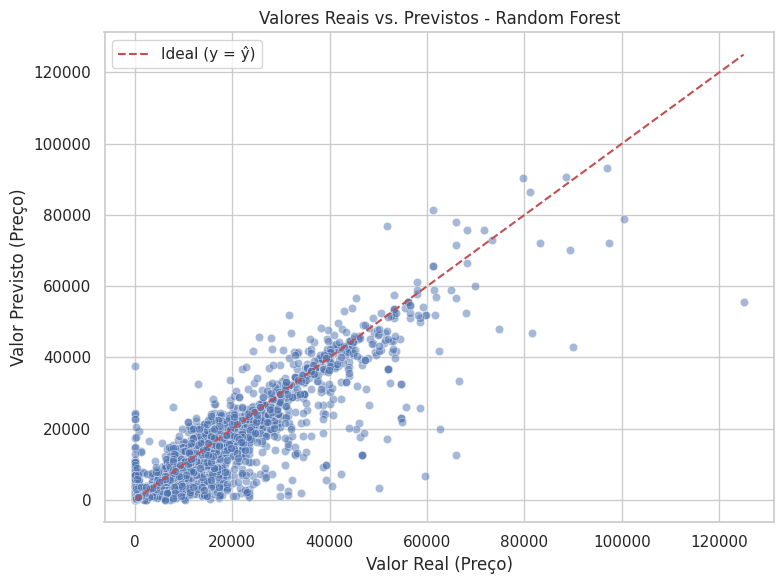

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal (y = ŷ)')
plt.xlabel("Valor Real (Preço)")
plt.ylabel("Valor Previsto (Preço)")
plt.title("Valores Reais vs. Previstos - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


                     Feature  Importance
4                    Airbags    0.209247
2                    Mileage    0.170388
5                    car_age    0.130472
116  Gear box type_Tiptronic    0.067857
0                       Levy    0.053694
109     Leather interior_Yes    0.038916
1              Engine volume    0.038361
43                 Model_FIT    0.026459
111         Fuel type_Hybrid    0.021908
98               Color_White    0.017123
91                Color_Grey    0.012295
85               Color_Black    0.011565
117   Gear box type_Variator    0.010300
103            Category_Jeep    0.010250
20       Manufacturer_TOYOTA    0.009811
96              Color_Silver    0.009586
107           Category_Sedan    0.007821
102       Category_Hatchback    0.007415
113         Fuel type_Petrol    0.007008
121       Drive wheels_Front    0.006992


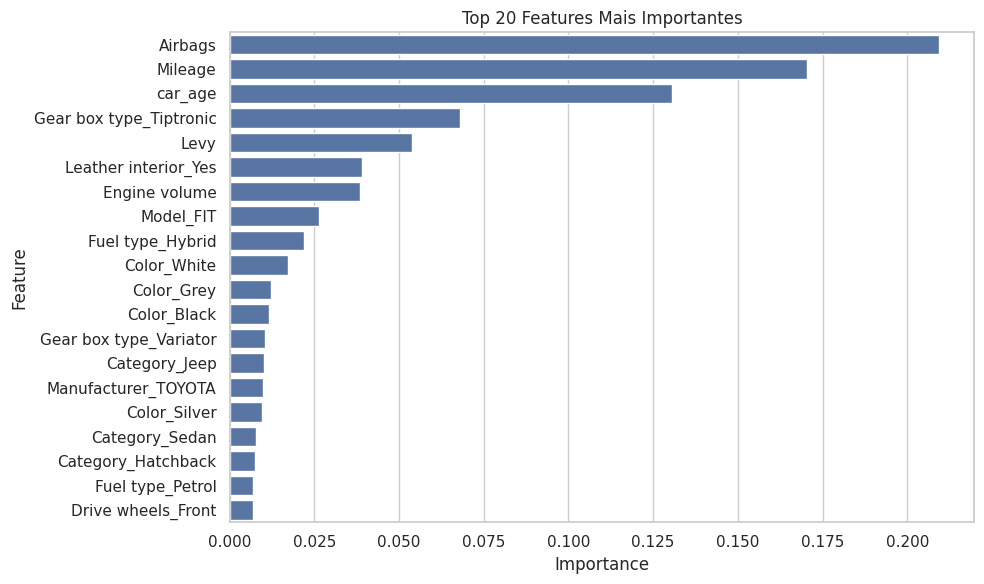

In [ ]:
# Nomes das colunas numéricas
numeric_feature_names = numeric_cols

# Nomes das colunas categóricas após one-hot encoding
categorical_feature_names = encoder.get_feature_names_out(categorical_cols)

# Combina todos os nomes
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])
importances = regressor.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(20))  # Top 20 mais importantes

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Features Mais Importantes')
plt.tight_layout()
plt.show()


# Modelo 2 LGBM Regressor

In [ ]:
# Modelo LGBM
lgbm = LGBMRegressor(random_state=42)

# Grade de parâmetros a testar
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 8, 10],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Treinamento com os dados
grid_search.fit(X_train_final, y_train_log)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Resultados
print("✅ Melhor combinação de hiperparâmetros:")
print(grid_search.best_params_)

# Avaliação no conjunto de teste
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE (teste): {rmse:.2f}")
print(f"📈 R² (teste): {r2:.4f}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 10606, number of used features: 119
[LightGBM] [Info] Start training from score 8.980916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


parece que o modelo baseado no gradiente boost está tendo problemas relacionados a encontrar splits com ganho positivo, provavelmente se dá a quantidade grande de colunas dummies provenientes do one hot encoding

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 RMSE: 8354.45
📈 R² Score: 0.6731


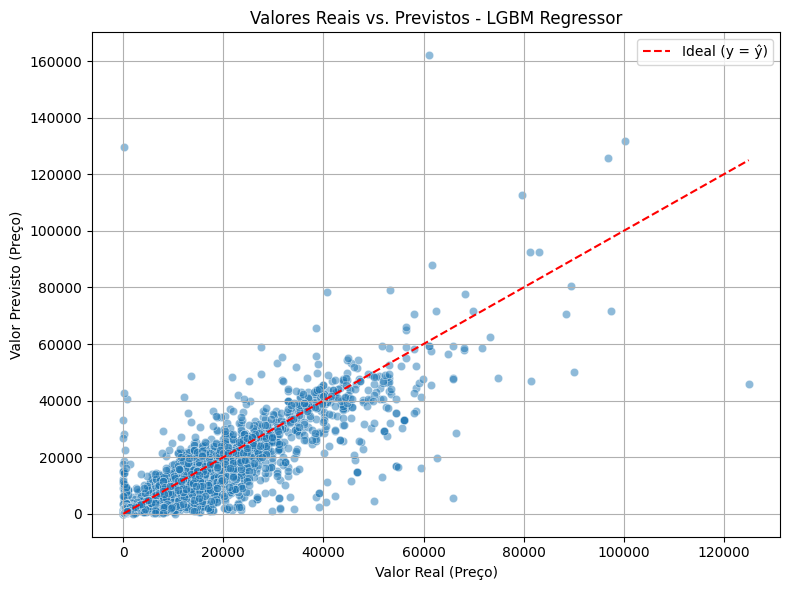

In [ ]:

y_pred_log = best_model.predict(X_test_final)

# Reverte o log para a escala original do preço
y_pred = np.expm1(y_pred_log)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.4f}")

# Gráfico: Real vs Previsto
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal (y = ŷ)')
plt.xlabel("Valor Real (Preço)")
plt.ylabel("Valor Previsto (Preço)")
plt.title("Valores Reais vs. Previstos - LGBM Regressor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

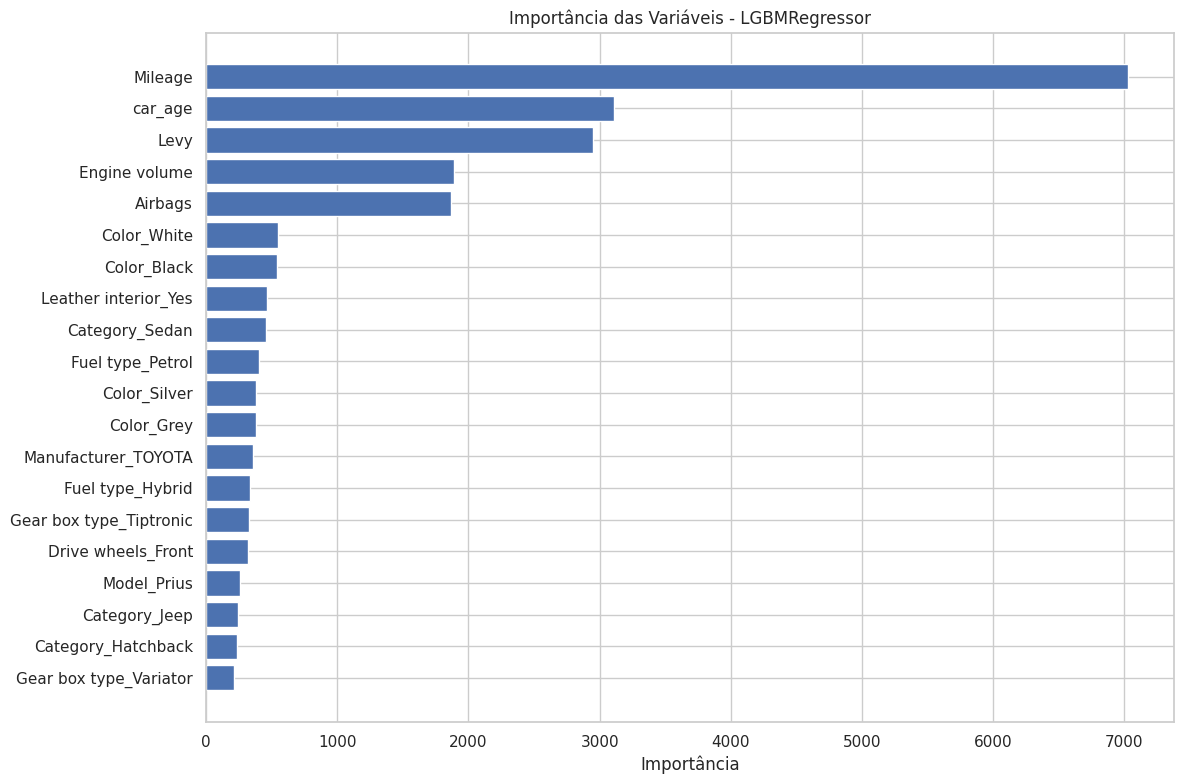

In [ ]:
importances = best_model.feature_importances_

# Obter os nomes das features (numéricas + categóricas one-hot)
feature_names = numeric_cols + list(encoder.get_feature_names_out(categorical_cols))

# Ordenar por importância
indices = np.argsort(importances)[::-1]

# Plotar gráfico de importâncias
plt.figure(figsize=(12, 8))
plt.title("Importância das Variáveis - LGBMRegressor")
plt.barh(range(20), np.array(importances)[indices[:20]][::-1], align="center")
plt.yticks(range(20), np.array(feature_names)[indices[:20]][::-1])
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

# Modelo 3 CatBoost Classifier

In [ ]:

# Discretização em faixas
y_class = pd.qcut(y, q=4, labels=['baixo', 'médio', 'alto', 'muito alto'])
faixas = pd.qcut(y, q=4)
print('Intervalo das classes geradas:', faixas.unique().sort_values())
print('Número de exemplares por classe:', y_class.value_counts())

# Divide os dados com a mesma estrutura que X_train_final já tem
y_train_class = y_class.loc[y_train.index]
y_test_class = y_class.loc[y_test.index]

# Instancia o modelo
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=7,
    verbose=0,
    random_state=42
)

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    cat_model,
    X_train_final,
    y_train_class,
    cv=cv,
    scoring='f1_macro'
)

print(f"F1 Macro médio (validação cruzada): {np.mean(scores):.4f}")
print(f"Desvio padrão dos F1s: {np.std(scores):.4f}")

# Treina no conjunto completo de treino após a validação
cat_model.fit(X_train_final, y_train_class, verbose=100)

# Avaliação no conjunto de teste
y_pred_class = cat_model.predict(X_test_final)
print("Relatório no conjunto de teste:")
print(classification_report(y_test_class, y_pred_class))

Intervalo das classes geradas: [(0.999, 4861.0], (4861.0, 13799.0], (13799.0, 22197.0], (22197.0, 136420.0]]
Categories (4, interval[float64, right]): [(0.999, 4861.0] < (4861.0, 13799.0] < (13799.0, 22197.0] <
                                           (22197.0, 136420.0]]
Número de exemplares por classe: Price
baixo         3362
muito alto    3314
médio         3294
alto          3288
Name: count, dtype: int64
F1 Macro médio (validação cruzada): 0.7926
Desvio padrão dos F1s: 0.0065
0:	learn: 1.3079218	total: 13.9ms	remaining: 13.9s
100:	learn: 0.6406564	total: 1.89s	remaining: 16.8s
200:	learn: 0.5368377	total: 3.89s	remaining: 15.5s
300:	learn: 0.4739705	total: 5s	remaining: 11.6s
400:	learn: 0.4303415	total: 6.07s	remaining: 9.06s
500:	learn: 0.3980408	total: 7.14s	remaining: 7.12s
600:	learn: 0.3695532	total: 8.22s	remaining: 5.46s
700:	learn: 0.3458287	total: 9.3s	remaining: 3.96s
800:	learn: 0.3247833	total: 10.4s	remaining: 2.58s
900:	learn: 0.3077193	total: 11.5s	remaining: 1.

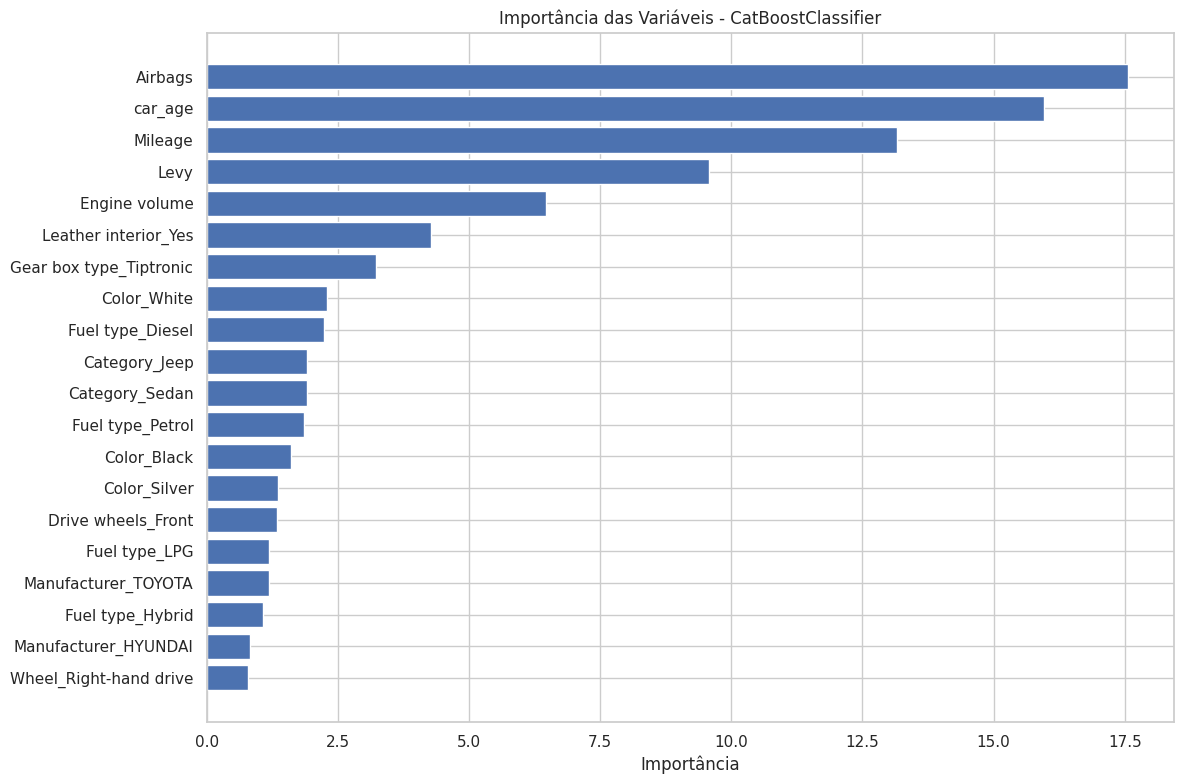

In [ ]:

# Importância das features
importances = cat_model.get_feature_importance()
feature_names = numeric_cols + list(encoder.get_feature_names_out(categorical_cols))

# Ordenar por importância
sorted_idx = np.argsort(importances)[::-1]

# Plotar gráfico
plt.figure(figsize=(12, 8))
plt.title("Importância das Variáveis - CatBoostClassifier")
plt.barh(range(20), np.array(importances)[sorted_idx[:20]][::-1])
plt.yticks(range(20), np.array(feature_names)[sorted_idx[:20]][::-1])
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

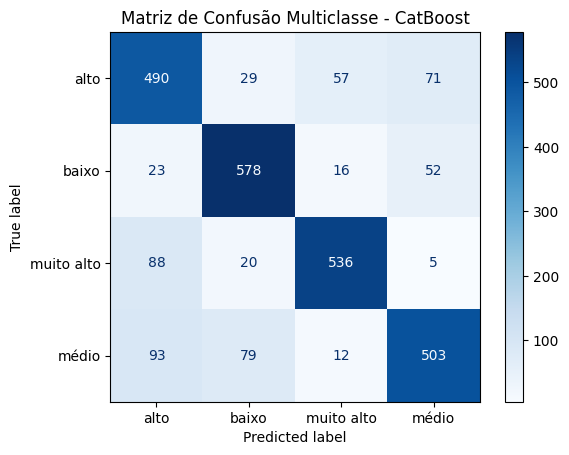

In [ ]:

cm = confusion_matrix(y_test_class, y_pred_class, labels=cat_model.classes_)

# Exibe a matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_model.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão Multiclasse - CatBoost")
plt.show()

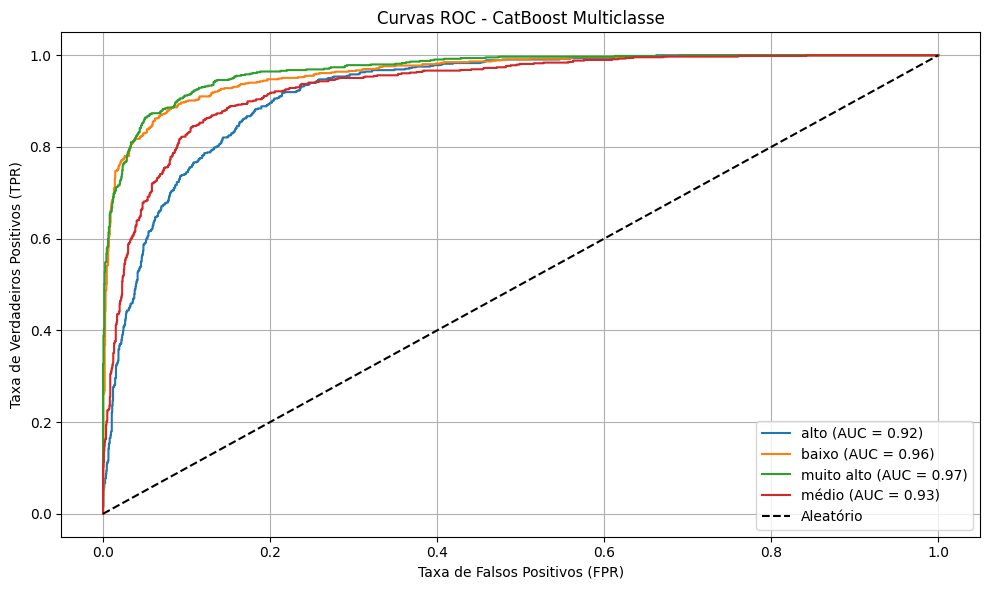

In [ ]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test_class)

y_test_bin = label_binarize(y_test_encoded, classes=np.arange(len(le.classes_)))

y_score = cat_model.predict_proba(X_test_final)

# 4. Calcular curva ROC e AUC para cada classe
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.title("Curvas ROC - CatBoost Multiclasse")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------------------------